# CNN for time series analysis

In [17]:
%pip install tensorflow==2.15

  Using cached tensorflow-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (3.6 kB)
  Using cached tensorflow_macos-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (4.2 kB)
  Using cached ml_dtypes-0.2.0-cp311-cp311-macosx_10_9_universal2.whl.metadata (20 kB)
  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
  Using cached wrapt-1.14.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.7 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached google_auth_oauthlib-1.2.2-py3-none-any.whl.metadata (2.7 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached requests_oauthlib-2.0.0-py2.py3-none-any.whl.metadata (11 kB)
  Using cac

In [102]:
import sys
import os
sys.path.append(os.path.abspath("..")) 

import numpy as np
import pandas as pd
import plotly_express as px
from datetime import datetime 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from functions_laura.Data_processing import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import load_model


![CNN](CNN-wibawa_JBD_2022.png)

### Data normalization

Data normalization is essential for CNN because it can scale the attribute into a specific range required by the activation function. This study uses Min–Max normalization.

## Exponential smoothing with optimum $\alpha$

The smoothed data $ {S}_{t} $ is the result of smoothing the raw data $ {\{X}_{t}\} $. The smoothing factor, $\alpha$ is a value that determines the level of smoothing. The range of $\alpha$ is between 0 and 1 (0 ≤ alpha ≤ 1). When $\alpha$ close to 1, the learning process is fast because it has a less smoothing effect. In contrast, values of $\alpha$ closer to 0 have a more significant smoothing effect and are less responsive to recent changes (slow learning).

How to determine optimum $\alpha$:

$$ Optimum \alpha ={ \alpha }_{max}- \frac{\frac{1}{n} \sum_{t=1}^{n}{ X}_{t}}{{ X}_{ max}- { X}_{ min}} $$


This is the optimum smoothing:

$$ {S}_{t}={ S}_{t-1} +\frac{\left({ X}_{ max}- { X}_{ min}\right)-\frac{1}{n}\sum_{t=1}^{n}{ X}_{t}}{{{X}_{ max}- X}_{ min}}({ X}_{t}-{ S}_{t-1}) $$

## CNN with lucas hidden layers

The input layer used one feature since it is a univariate model. Flatten was used for input to get a fully connected layer. The fully connected layer contains dense for the number of hidden layers.

Instead of using a random number, we used the Lucas number to determine the hidden layer. The Lucas number (Ln) is recursive in the same way as the Fibonacci sequence (Fn), with each term equal to the sum of the two preceding terms, yet with different initial values. This sequence was selected since it provides a golden ratio number. The golden ratio emerges in nature, demonstrating that this enchanted number is ideal for determining the optimal solution to numerous covering problems such as arts, engineering, and financial forecasting. In this study, the Lucas number starts from three and ends with the last number before 100, which is 76. We limited the number of hidden layers to avoid the impact of time consumption and efficiency performance. Overall, we used 3, 4, 7, 11, 18, 29, 47, and 76 [40] for the numbers of hidden layers.

![hidden](Lucas-hidden.png)



loading of the data and creating the needed data from the dataframe

In [2]:
from functions_laura.Data_processing import resample_with_seasonality
from functions_laura.Data_processing import resample
from functions_laura.Data_processing import add_seasonal
from functions_laura.Data_processing import one_station_resample_with_seasonality
from functions_laura.Data_processing import train_test_split
from functions_laura.Data_cleaning import data_cleaning_datetime

In [3]:
df = pd.read_parquet('../data/hamburg_raw.parquet')

In [4]:
df = data_cleaning_datetime(df)

/Users/laurabrylka/Documents/Git/FuelProphet/functions_laura/Data_cleaning.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = df['date'].apply(lambda x: datetime.strptime(x.split("+")[0], "%Y-%m-%d %H:%M:%S"))


do the train-test split

In [5]:
train_df, test_df = train_test_split(df)

get data of one station

In [6]:
# only compute the seasonality on the training data!
train_df = one_station_resample_with_seasonality(train_df, uuid='30a50253-2339-469d-a77c-86713d9f5f7f')

Add the training seasonality to the test set

In [7]:
# Take first 288 values (one complete cycle) and repeat
seasonal_pattern = train_df['seasonal_component'].iloc[:288].values
test_df['seasonal_component'] = np.tile(seasonal_pattern, len(test_df)//288 + 1)[:len(test_df)]

# Verify no NaNs
print(test_df.isna().sum())

station_uuid             0
name                     0
brand                    0
street                   0
house_number          9031
post_code                0
city                     0
latitude                 0
longitude                0
first_active             0
openingtimes_json        0
date                     0
diesel                   0
e5                       0
e10                      0
dieselchange             0
e5change                 0
e10change                0
datetime                 0
seasonal_component       0
dtype: int64


/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/ipykernel_41542/1156590565.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['seasonal_component'] = np.tile(seasonal_pattern, len(test_df)//288 + 1)[:len(test_df)]


we remove the unnecessary data from test df and add the seasonal component from the training data

In [8]:
test_df = test_df[test_df['station_uuid'] == '30a50253-2339-469d-a77c-86713d9f5f7f']

In [9]:
test_df = resample_with_seasonality(test_df)

In [10]:
test_df_ = pd.DataFrame({
    'datetime': test_df['datetime'],
    'e5' : test_df['e5'],
    'seasonal_component' : test_df['seasonal_component']
})

set datetime as index:

In [11]:
test_df_.set_index('datetime', inplace=True)
train_df.set_index('datetime', inplace=True)

check our data in a plot

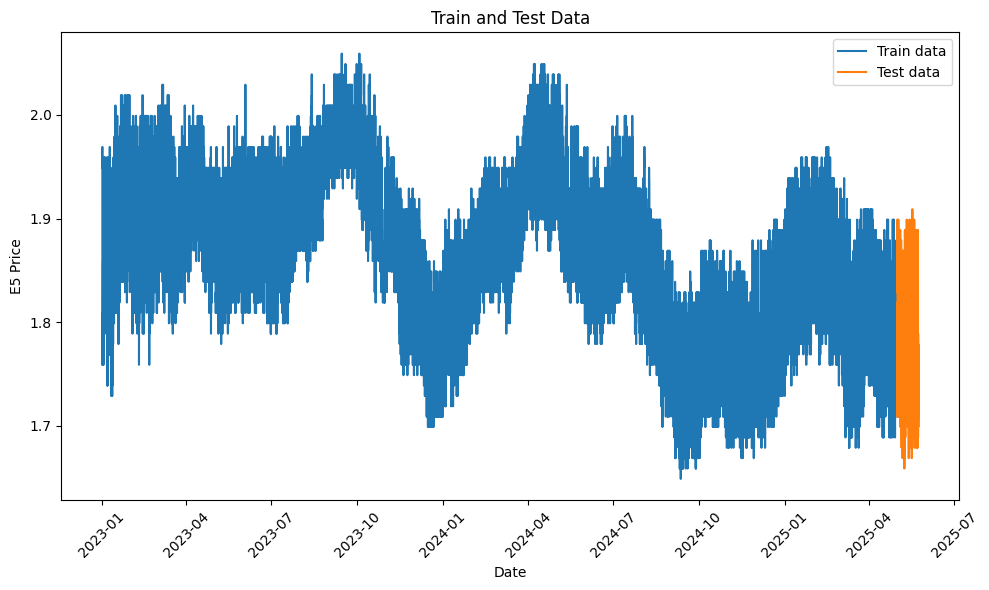

In [12]:
# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['e5'], label='Train data')
plt.plot(test_df_.index, test_df_['e5'], label='Test data')

plt.xlabel('Date')
plt.ylabel('E5 Price')
plt.title('Train and Test Data')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

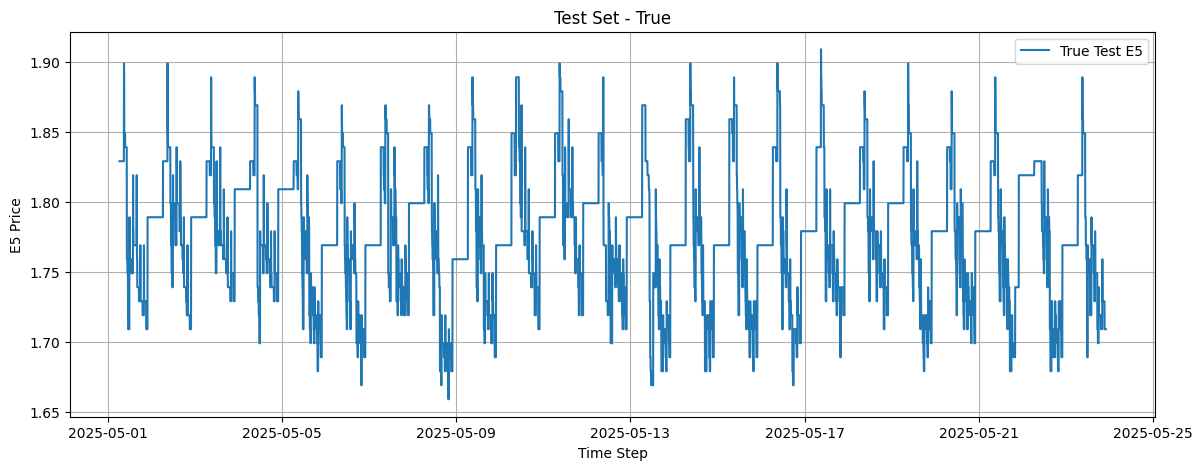

In [13]:
# Plot Test
plt.figure(figsize=(14, 5))
plt.plot(test_df_['e5'], label='True Test E5')
plt.title("Test Set - True")
plt.xlabel("Time Step")
plt.ylabel("E5 Price")
plt.legend()
plt.grid(True)
plt.show()

we scale the data

In [14]:
scaler = MinMaxScaler()
scaler.fit(train_df[['e5', 'seasonal_component']])
scaled_train = scaler.transform(train_df[['e5', 'seasonal_component']])
scaled_test = scaler.transform(test_df_[['e5', 'seasonal_component']])

In [15]:
scaled_train[:5]

array([[0.73170732, 0.70150393],
       [0.73170732, 0.70287675],
       [0.73170732, 0.70298269],
       [0.73170732, 0.70308863],
       [0.73170732, 0.70308899]])

In [16]:
scaled_test[:5]

array([[0.43902439, 1.05930296],
       [0.43902439, 1.0593171 ],
       [0.43902439, 1.05933125],
       [0.43902439, 1.0593454 ],
       [0.43902439, 1.05935954]])

### Transforming the data...
so it can fit into my model. We are using a sliding window of 288 (1 day). After every 288 e5 prices, we look at the price that comes after it. 
$X$ is an array consisting of all the sequences, so it has 288 columns.
$y$ is a 1D array of all these values that come after the 288 (= the next step)

$X$ and $y$ have 288 less rows than the original df, because:

| i    | Input `X[i]` (rows used) | Target `y[i]` |
| ---- | ------------------------ | ------------- |
| 0    | rows 0 to 287            | row 288, E5   |
| 1    | rows 1 to 288            | row 289, E5   |
| 2    | rows 2 to 289            | row 290, E5   |
| ...  | ...                      | ...           |
| 9711 | rows 9711 to 9998        | row 9999, E5  |


In [17]:
def create_sequences(data, window_size, target_col_index):
    """Create sequences for time series prediction.
    
    Args:
        data: Scaled input data with shape (samples, features)
        window_size: Number of time steps to look back
        target_col_index: Index of the target column to predict
        
    Returns:
        X: Input sequences with shape (samples, window_size, features)
        y: Target values with shape (samples,)
    """
    X = []
    y = []
    for i in range(len(data) - window_size):
        # Get sequence of all features
        sequence = data[i:(i + window_size)]
        X.append(sequence)
        # Get next value of target feature
        target = data[i + window_size, target_col_index]
        y.append(target)
    return np.array(X), np.array(y)

# Create sequences with e5 as target (index 0)
window_size = 288  # one day of 5-min steps
target_col_index = 0  # e5 price is in first column
X, y = create_sequences(scaled_train, window_size, target_col_index)

# Print shapes to verify
print(f"Input shape: {X.shape}")  # Should be (samples, 288, 2)
print(f"Target shape: {y.shape}") # Should be (samples,)

Input shape: (244410, 288, 2)
Target shape: (244410,)


In [18]:
print(X.shape)

(244410, 288, 2)


In [19]:
X[:5]

array([[[0.73170732, 0.70150393],
        [0.73170732, 0.70287675],
        [0.73170732, 0.70298269],
        ...,
        [0.51219512, 0.51094252],
        [0.51219512, 0.51157669],
        [0.51219512, 0.51157706]],

       [[0.73170732, 0.70287675],
        [0.73170732, 0.70298269],
        [0.73170732, 0.70308863],
        ...,
        [0.51219512, 0.51157669],
        [0.51219512, 0.51157706],
        [0.73170732, 0.70150393]],

       [[0.73170732, 0.70298269],
        [0.73170732, 0.70308863],
        [0.73170732, 0.70308899],
        ...,
        [0.51219512, 0.51157706],
        [0.73170732, 0.70150393],
        [0.73170732, 0.70287675]],

       [[0.73170732, 0.70308863],
        [0.73170732, 0.70308899],
        [0.73170732, 0.70308936],
        ...,
        [0.73170732, 0.70150393],
        [0.73170732, 0.70287675],
        [0.73170732, 0.70298269]],

       [[0.73170732, 0.70308899],
        [0.73170732, 0.70308936],
        [0.73170732, 0.70308973],
        ...,
        [

In [20]:
y.shape

(244410,)

In [21]:
y[:5]

array([0.73170732, 0.73170732, 0.73170732, 0.73170732, 0.73170732])

We prepare the Test data -> put in 3 days and predict one day

In [22]:
# Step 1: Calculate window sizes
window_size = 288         # 1 day
days_input = 3
days_output = 1

total_input_steps = days_input * window_size
total_target_steps = days_output * window_size

# Step 2: Get the slice of scaled_test for exactly what you need
# These are the last (3 days + 1 day) = 1152 samples
reduced_scaled_test = scaled_test[-(total_input_steps + total_target_steps):]

# Step 3: Create sequences
X_test_final, y_test_final = create_sequences(reduced_scaled_test, window_size, target_col_index)

# Step 4: Keep only the last 288 predicted targets (the last day)
# The last 288 y-values correspond to the last day
X_forecast = X_test_final[-total_target_steps:]
y_forecast = y_test_final[-total_target_steps:]


In [24]:
print(y_test_final[0])

0.3170731707317067


In [25]:
print("Scaler mins:", scaler.data_min_)
print("Scaler maxs:", scaler.data_max_)


Scaler mins: [ 1.649      -0.05303547]
Scaler maxs: [2.059      0.05853209]


In [26]:
# check for overlapping timestamps
train_times = set(train_df.index)
test_times = set(test_df_.index)
overlap = train_times.intersection(test_times)
print(f"Overlap: {len(overlap)}")


Overlap: 0


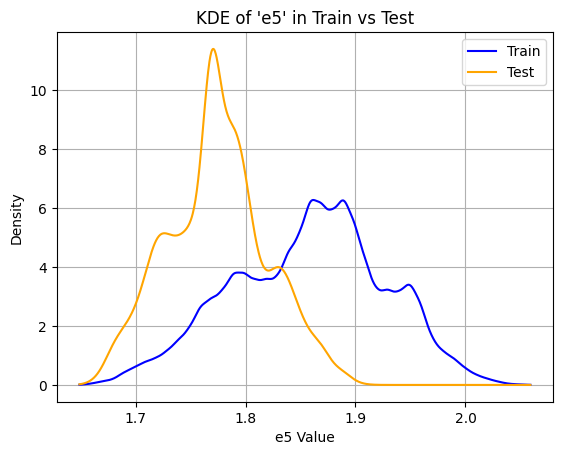

In [27]:
# check distribution of train and test
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np

x_train = train_df["e5"].dropna()
x_test = test_df["e5"].dropna()

kde_train = gaussian_kde(x_train)
kde_test = gaussian_kde(x_test)

x_vals = np.linspace(min(x_train.min(), x_test.min()), max(x_train.max(), x_test.max()), 1000)
plt.plot(x_vals, kde_train(x_vals), label='Train', color='blue')
plt.plot(x_vals, kde_test(x_vals), label='Test', color='orange')
plt.legend()
plt.title("KDE of 'e5' in Train vs Test")
plt.xlabel("e5 Value")
plt.ylabel("Density")
plt.grid(True)
plt.show()


In [28]:
scaled_test.shape

(6522, 2)

In [30]:
y_test_final.shape

(864,)

### Model training

In [31]:

# Example multivariate time-series data
# Assume 'data' is a NumPy array of shape (samples, timesteps, features)
# For instance, data.shape = (1000, 30, 5) for 1000 samples, 30 timesteps, and 5 features

# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(288, 2))) # 1-dimensional deconvolution
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))  # Output layer for forecasting

model.compile(optimizer='adam', loss='mse')

# Fit the model
# Assume 'X_train' and 'y_train' are your training data and labels
# model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

more complex model

In [103]:
# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(288, 2)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


In [104]:
model.fit(X, y, epochs=30, batch_size=32)

Epoch 1/30
7638/7638 [==============================] - 66s 9ms/step - loss: 0.0178
Epoch 2/30
7638/7638 [==============================] - 61s 8ms/step - loss: 0.0026
Epoch 3/30
7638/7638 [==============================] - 65s 8ms/step - loss: 0.0024
Epoch 4/30
7638/7638 [==============================] - 61s 8ms/step - loss: 0.0021
Epoch 5/30
7638/7638 [==============================] - 63s 8ms/step - loss: 0.0019
Epoch 6/30
7638/7638 [==============================] - 65s 9ms/step - loss: 0.0018
Epoch 7/30
7638/7638 [==============================] - 63s 8ms/step - loss: 0.0018
Epoch 8/30
7638/7638 [==============================] - 64s 8ms/step - loss: 0.0018
Epoch 9/30
7638/7638 [==============================] - 63s 8ms/step - loss: 0.0018
Epoch 10/30
7638/7638 [==============================] - 63s 8ms/step - loss: 0.0017
Epoch 11/30
7638/7638 [==============================] - 71s 9ms/step - loss: 0.0017
Epoch 12/30
7638/7638 [==============================] - 69s 9ms/step - lo

save the model

In [106]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
uuid = '30a50253-2339-469d-a77c-86713d9f5f7f'
fuel= 'e5'
#model.save(f"fuel_price_cnn_model_{timestamp}.h5")
model.save(f"../models_laura/One_station_CNN_BIGGER_model{timestamp}_{fuel}_{uuid}")

INFO:tensorflow:Assets written to: ../models_laura/One_station_CNN_BIGGER_model20250611_2147_e5_30a50253-2339-469d-a77c-86713d9f5f7f/assets


INFO:tensorflow:Assets written to: ../models_laura/One_station_CNN_BIGGER_model20250611_2147_e5_30a50253-2339-469d-a77c-86713d9f5f7f/assets


predictions

In [116]:
#model = load_model('../models_laura/One_station_CNN_20250611_1639_e5_30a50253-2339-469d-a77c-86713d9f5f7f') #first model: something wrong
model1 = load_model('../models_laura/One_station_CNN_20250611_1804_e5_30a50253-2339-469d-a77c-86713d9f5f7f') # second model, trained on whole training set, good model!
model2 = load_model('../models_laura/../models_laura/One_station_CNN_BIGGER_model20250611_2147_e5_30a50253-2339-469d-a77c-86713d9f5f7f') # third model, trained on whole training set with bigger model.

# Real forecasting use case
## we predict the last day while putting in the three days before

In [117]:
# Predict only the last day
y_pred_forecast = model1.predict(X_forecast)
y_pred_forecast2 = model2.predict(X_forecast)

9/9 [==============================] - 0s 3ms/step


Reverse the scaling

In [118]:
def inverse_scale(preds, original_data, target_index, scaler):
    """Inverse scale predictions by placing them into a dummy array 
    and applying scaler.inverse_transform."""
    dummy = np.zeros((len(preds), original_data.shape[1]))
    dummy[:, target_index] = preds.flatten()
    return scaler.inverse_transform(dummy)[:, target_index]

In [119]:
y_pred = inverse_scale(y_pred_forecast, scaled_train, target_index=0, scaler=scaler)
y_pred2 = inverse_scale(y_pred_forecast2, scaled_train, target_index=0, scaler=scaler)

Reattach the datetime to y_pred

In [122]:
n_predictions = len(y_pred)
start_datetime = pd.to_datetime("2025-05-22 22:00")
time_index = pd.date_range(start=start_datetime, periods=n_predictions, freq="5min")

# Combine into a DataFrame
y_pred_df = pd.DataFrame({
    "datetime": time_index,
    "Predicted E5": y_pred
})

print(y_pred_df.head())

             datetime  Predicted E5
0 2025-05-22 22:00:00      1.714439
1 2025-05-22 22:05:00      1.804818
2 2025-05-22 22:10:00      1.799226
3 2025-05-22 22:15:00      1.786300
4 2025-05-22 22:20:00      1.772294


In [123]:
n_predictions = len(y_pred2)
start_datetime = pd.to_datetime("2025-05-22 22:00")
time_index = pd.date_range(start=start_datetime, periods=n_predictions, freq="5min")

# Combine into a DataFrame
y_pred_df2 = pd.DataFrame({
    "datetime": time_index,
    "Predicted E5": y_pred2
})

print(y_pred_df2.head())

             datetime  Predicted E5
0 2025-05-22 22:00:00      1.709924
1 2025-05-22 22:05:00      1.748005
2 2025-05-22 22:10:00      1.772271
3 2025-05-22 22:15:00      1.736045
4 2025-05-22 22:20:00      1.725960


In [124]:
y_pred_df.set_index('datetime', inplace=True)
y_pred_df2.set_index('datetime', inplace=True)

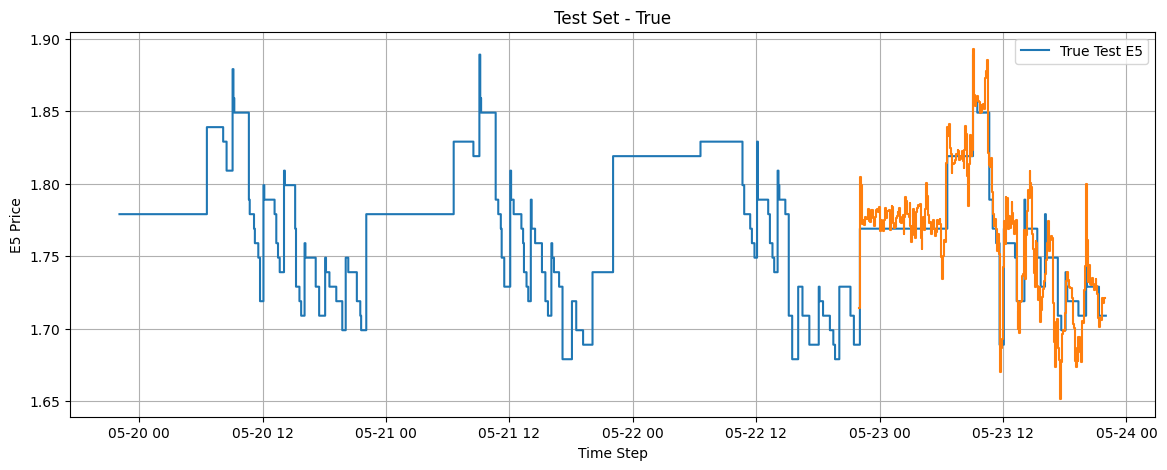

In [128]:
# Plot Test
plt.figure(figsize=(14, 5))
plt.plot(test_df_['e5'].iloc[-1152:], label='True Test E5', drawstyle='steps-post')
plt.plot(y_pred_df, drawstyle='steps-post')
plt.title("Test Set - True")
plt.xlabel("Time Step")
plt.ylabel("E5 Price")
plt.legend()
plt.grid(True)
plt.show()

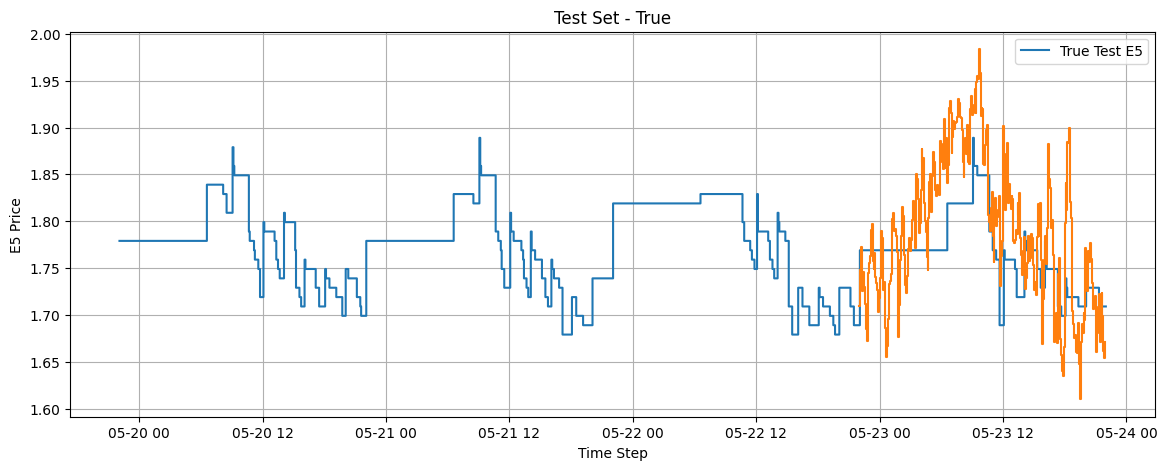

In [127]:
# Plot Test
plt.figure(figsize=(14, 5))
plt.plot(test_df_['e5'].iloc[-1152:], label='True Test E5', drawstyle='steps-post')
plt.plot(y_pred_df2, drawstyle='steps-post')
plt.title("Test Set - True")
plt.xlabel("Time Step")
plt.ylabel("E5 Price")
plt.legend()
plt.grid(True)
plt.show()

# Autoregressive prediction

In [97]:
# Then you run auto-regressive prediction:
from tqdm import tqdm

# Define constants
window_size = 288
forecast_days = 1
steps_to_predict = forecast_days * 288
target_index = 0  # Assuming 'e5' is the first column in scaling

# You must cut your test set like this:

test_start = pd.to_datetime("2025-05-21")
test_end = pd.to_datetime("2025-05-23")

input = test_df_[(test_df_.index >= test_start) & 
                       (test_df_.index < test_start + pd.Timedelta(days=7))]

# You use only these first 7 days (7 × 288 = 2016 samples) to form the initial sliding window input:
input_seq = input[["e5", "seasonal_component"]]
input_scaled = scaler.transform(input_seq)


# 2. Initialize sliding window with last 288 time steps (one day)
last_window = input_scaled[-window_size:].copy()

In [98]:
# 3. Autoregressive prediction
predictions_scaled = []
start_index = (test_df_.index.get_loc(test_start))
 # Starting point (after first 7 days)

all_seasonal = test_df_["seasonal_component"].values
seasonal_pattern_length = 288  # One day pattern

for step in tqdm(range(steps_to_predict)):  # Changed _ to step
    input_window = last_window.reshape(1, window_size, -1)  # shape: (1, 288, 2)
    
    # Predict next step
    next_pred_scaled = model.predict(input_window, verbose=0)[0, 0]  # shape: scalar

    # Get seasonal component by wrapping around the daily pattern
    seasonal_idx = (start_index + step) % seasonal_pattern_length
    next_seasonal = all_seasonal[seasonal_idx]
    
    # Create properly formatted input for scaler
    next_seasonal_scaled = scaler.transform([[0, next_seasonal]])[0, 1]
    
    next_input = np.zeros((2,))
    next_input[target_index] = next_pred_scaled
    next_input[1 - target_index] = next_seasonal_scaled

    # Append prediction and slide window
    predictions_scaled.append(next_input[target_index])
    last_window = np.vstack([last_window[1:], next_input])

  0%|          | 0/288 [00:00<?, ?it/s]/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
  1%|          | 2/288 [00:00<00:16, 16.86it/s]/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib

In [99]:
# First, inverse scale the predictions
predictions_inv = inverse_scale(np.array(predictions_scaled).reshape(-1, 1), 
                              scaled_train, 
                              target_index=0, 
                              scaler=scaler)

# Create DataFrame with inverse-scaled predictions
n_predictions = len(predictions_inv)
start_datetime = pd.to_datetime("2025-05-22 22:00")
time_index = pd.date_range(start=start_datetime, periods=n_predictions, freq="5min")

y_pred_df = pd.DataFrame({
    "datetime": time_index,
    "Predicted E5": predictions_inv
})

y_pred_df.set_index('datetime', inplace=True)

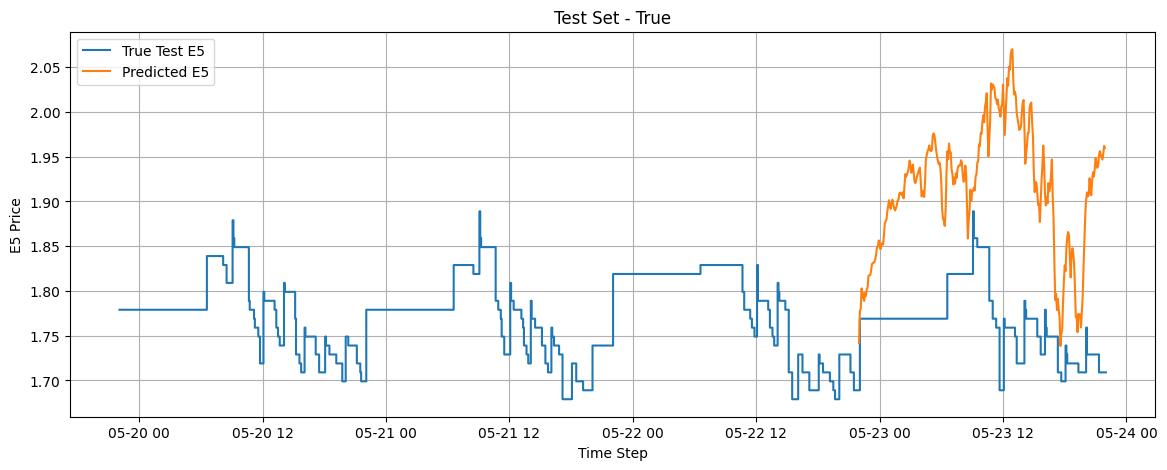

In [100]:
# Plot Test
plt.figure(figsize=(14, 5))
plt.plot(test_df_['e5'].iloc[-1152:], label='True Test E5', drawstyle='steps-post')
plt.plot(y_pred_df, label='Predicted E5')
plt.title("Test Set - True")
plt.xlabel("Time Step")
plt.ylabel("E5 Price")
plt.legend()
plt.grid(True)
plt.show()